In [ ]:
! pip install roboflow -q
! pip install torchmetrics -q

# 1.Importing  the libraries


In [2]:
import numpy as np
from roboflow import Roboflow
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead, det_utils
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.anchor_utils import AnchorGenerator
import torchvision.transforms.functional as tf
import albumentations as A
from torchmetrics.detection import MeanAveragePrecision
import matplotlib.patches as patches
import torch.nn as nn

# 2.Initializing the path


In [3]:
rf = Roboflow(api_key="PXdjogidaWyDpVU6sdJa")
project = rf.workspace("kpi-zitnq").project("landmines-vxldd")
version = project.version(5)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...


In [4]:
np.random.seed(42)
torch.manual_seed(42)
train_dir = dataset.location + "/train"
valid_dir = dataset.location + "/valid"

# 3.Configurtion Parameters

In [5]:
classes=["background","mine"]
num_classes=len(classes)
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size=8
epochs=30
learning_rate=3e-5
model_weights_file="model.pth"
threshold=0.25
iou_threshold=0.75
image_width = 480
image_height = 480
distribution = 0.85

## 3.5 Parse XML

In [6]:
def parse_xml(annot_path):
    # Функція для розбору XML файлу з анотаціями
    # Вхідний параметр: annot_path - шлях до XML файлу з анотаціями

    # Парсимо XML файл
    tree=ET.parse(annot_path)
    root=tree.getroot()

    # Отримуємо ширину та висоту зображення
    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]

    # Ітеруємось по всім об'єктам у кореневому елементі XML
    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

# 4.Data Augumentation


In [7]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(0.05, 0.05),
        rotate=(-25, 25),
        fit_output=True,
        p=0.7
    ),

    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.5),
    A.MotionBlur(blur_limit=5, p=0.2),

    # Універсальна обрізка, що працює на всіх версіях
    A.Resize(height=image_height, width=image_width),
    A.RandomCrop(height=int(image_height*0.9), width=int(image_width*0.9), p=0.7),
    A.Resize(height=image_height, width=image_width),
],
bbox_params=A.BboxParams(
    format="pascal_voc",
    min_visibility=0.15,
    label_fields=["labels"],
    clip=True
))

val_transform = A.Compose([
    A.Resize(height=image_height, width=image_width)
],
bbox_params=A.BboxParams(
    format="pascal_voc",
    min_visibility=0.15,
    label_fields=["labels"],
    clip=True
))

# 5.Custom Object Detection

In [8]:
class MineDetection(Dataset):
    def __init__(self, data_dir, transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform

        # Вибираємо всі JPG файли
        self.img_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".jpg")])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.data_dir, img_name)

        # Читаємо зображення
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Шукаємо XML
        annot_path = os.path.join(self.data_dir, img_name.replace(".jpg", ".xml"))
        boxes, height, width = parse_xml(annot_path)
        labels = [1] * len(boxes)

        # Трансформації
        if self.transform:
            transformed = self.transform(image=img, bboxes=boxes, labels=labels)
            img = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["labels"]

        # Якщо немає боксів
        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        # До тензора
        img = img / 255
        img = tf.to_tensor(img).float()

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "id": torch.tensor(idx)
        }

        return img, target


In [9]:
train_ds = MineDetection(train_dir, train_transform)
val_ds = MineDetection(valid_dir, val_transform)

# 7.Data Visualization

In [10]:
def show_bbox(img, target, color=(0, 255, 0)):
    # Конвертуємо зображення та анотації у формат NumPy для відображення
    img = np.transpose(img.cpu().numpy(), (1, 2, 0))
    boxes = target["boxes"].cpu().numpy().astype("int")
    labels = target["labels"].cpu().numpy()
    img = img.copy()  # Копіюємо зображення для уникнення змін у вихідному зображенні

    # Проходимося по кожному прямокутнику та мітці та відображаємо їх на зображенні
    for i, box in enumerate(boxes):
        idx = int(labels[i])  # Отримуємо мітку класу для поточного прямокутника
        text = classes[idx]  # Отримуємо назву класу за його міткою

        # Малюємо прямокутник та підпис на зображенні
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        y = box[1] - 10 if box[1] - 10 > 10 else box[1] + 10  # Обчислюємо вертикальну позицію тексту
        cv2.putText(img, text, (box[0], y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Додаємо текст

    return img

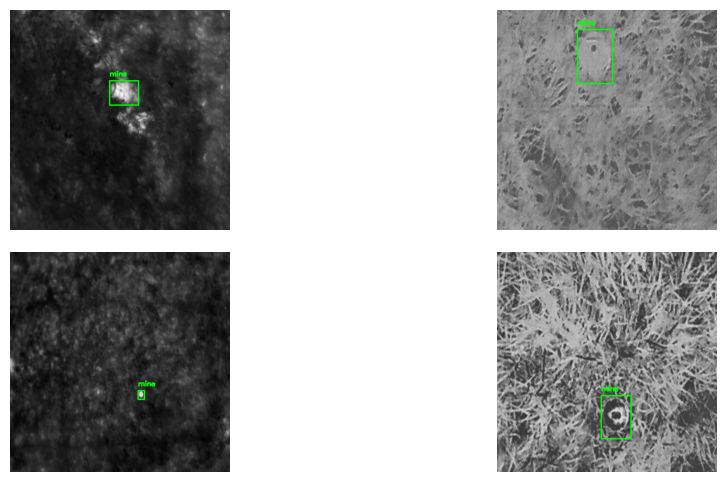

In [11]:
fig,axes=plt.subplots(2,2,figsize=(12,6))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

idxs=np.random.choice(range(len(val_ds)),4)
for i,idx in enumerate(idxs):
    img,target=val_ds[idx]
    output_img=show_bbox(img,target)
    ax[i].imshow(output_img)
    ax[i].axis("off")

# 8.Data Loader

In [12]:
def collate_fn(batch):

    return tuple(zip(*batch))

In [13]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# 9.Building the Model

In [14]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels = det_utils.retrieve_out_channels(model.backbone, (image_height, image_width))
num_anchors = model.anchor_generator.num_anchors_per_location()

model.head = SSDHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)


model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# 10. Sets up the optimizer and learning rate scheduler for training the model.

In [15]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

# Отримуємо тільки ті параметри моделі, які мають вимогу для навчання
parameters=[params for params in model.parameters() if params.requires_grad]

# Ініціалізуємо оптимізатор з навчальними параметрами та вказаною швидкістю навчання
optimizer=optim.Adam(parameters,lr=learning_rate)

# Ініціалізуємо планувальник швидкості навчання для зменшення швидкості навчання в разі зупинки покращень
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,  # Використовуємо створений оптимізатор
                                                  mode='min', # Режим мінімізації: шукаємо мінімум валідаційної функції втрат
                                                  factor=0.1, # Коефіцієнт, на який зменшується швидкість навчання
                                                  patience=7, # Кількість епох, протягом яких швидкість навчання не зменшується, перш ніж вважати, що навчання зупинилося
                                                  threshold=0.0001 # Мінімальна зміна в метриці, яка вважається покращенням
                                                  )

# 11.Training

In [16]:
def get_lr(optimizer):
    # Функція для отримання поточної швидкості навчання з оптимізатора

    # Перебираємо параметри оптимізатора
    for params in optimizer.param_groups:
        return params["lr"]

In [17]:
loss_history = {
    "training_loss": [],
    "validation_loss": []
}


train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

# Ініціалізуємо змінні для відстеження найкращих втрат та ваг моделі
best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

# Проводимо цикл навчання по вказаному числу епох
for epoch in range(epochs):

    # Ініціалізуємо втрати для тренувального та валідаційного наборів даних
    training_loss=0.0
    validation_loss=0.0

    # Отримуємо поточну швидкість навчання
    current_lr=get_lr(optimizer)

    # Переводимо модель у режим тренування
    model.train()

    # Проходимося по тренувальному DataLoader
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)

        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in t.items()} for t in targets]

            # Передаємо дані через модель та обчислюємо втрати
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()

    # Оновлюємо графік швидкості навчання на основі втрат валідації
    lr_scheduler.step(validation_loss)
    # Перевіряємо, чи змінилася поточна швидкість навчання
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    # Якщо поточні втрати валідації менші за найкращі втрати валідації
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")

    # Записуємо втрати для навчання та валідації у відповідні списки
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"epoch {epoch+1} from {epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"-"*50)

# Зберігаємо ваги найкращої моделі у файл
torch.save(best_weights,model_weights_file)

Updating Best Model weights
epoch 1 from 30
Training Loss: 0.785448542181051
Validation_loss: 0.6935562021118679

--------------------------------------------------
Updating Best Model weights
epoch 2 from 30
Training Loss: 0.6412532561403228
Validation_loss: 0.6371710954336175

--------------------------------------------------
Updating Best Model weights
epoch 3 from 30
Training Loss: 0.5968467770536336
Validation_loss: 0.5957915229636406

--------------------------------------------------
Updating Best Model weights
epoch 4 from 30
Training Loss: 0.5504779320842815
Validation_loss: 0.5594686677184286

--------------------------------------------------
Updating Best Model weights
epoch 5 from 30
Training Loss: 0.5215121941919424
Validation_loss: 0.5440325616281244

--------------------------------------------------
Updating Best Model weights
epoch 6 from 30
Training Loss: 0.5020797031192198
Validation_loss: 0.5262907235431269

--------------------------------------------------
Updat

In [33]:
import json

history_path = "/content/loss_history.json"

with open(history_path, "w") as f:
    json.dump(loss_history, f)

# 12.Loss Visualization.

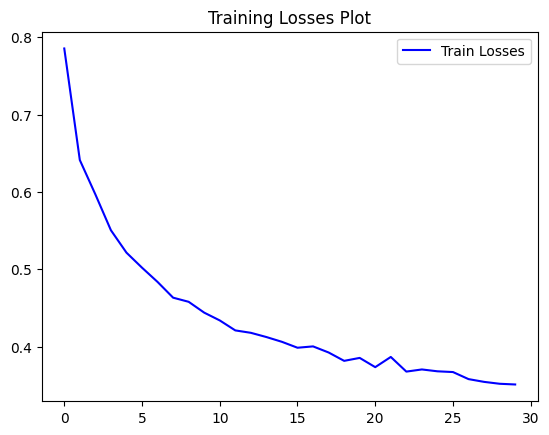

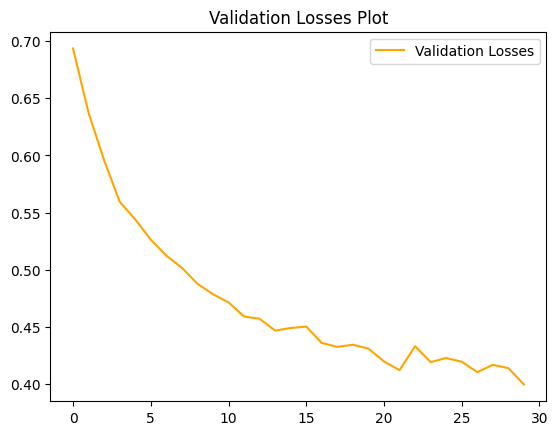

In [18]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],color='blue', label="Train Losses");
plt.title("Training Losses Plot")
plt.show()
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"], color='orange', label="Validation Losses");
plt.title("Validation Losses Plot")
plt.show()

# 13. Load a model.

In [25]:
model = ssd300_vgg16()
in_channels = det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors = model.anchor_generator.num_anchors_per_location()
model.head = SSDHead(in_channels, num_anchors, num_classes)

model.load_state_dict(torch.load("model.pth", map_location=device))
model.to(device)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

# 14.Preprocessing a image.

In [26]:
def preprocess_bbox(prediction):
    # Функція для обробки анотацій (областей обмеження) перед використанням

    processed_bbox = {}  # Ініціалізуємо словник для зберігання оброблених анотацій

    # Відфільтровуємо анотації (області обмеження) з низькими балами впевненості
    boxes = prediction["boxes"][prediction["scores"] >= threshold]
    scores = prediction["scores"][prediction["scores"] >= threshold]
    labels = prediction["labels"][prediction["scores"] >= threshold]

    # Виконуємо процедуру не максимального підтримання (NMS) для усунення дублікатів анотацій
    nms = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)

    # Зберігаємо області обмеження, бали впевненості та мітки, що пройшли фільтрацію NMS
    processed_bbox["boxes"] = boxes[nms]
    processed_bbox["scores"] = scores[nms]
    processed_bbox["labels"] = labels[nms]

    return processed_bbox  # Повертаємо оброблені анотації

# 15.Metrices.

In [28]:
metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)  # Ініціалізуємо метрику середньої точності для об'єктів

metric.to(device)  # Переміщуємо метрику на пристрій

model.eval()  # Переводимо модель у режим оцінювання

with torch.no_grad():  # Відключаємо обчислення градієнтів під час оцінювання
    for imgs, targets in val_dl:  # Проходимося по валідаційному DataLoader'у
        imgs = [img.to(device) for img in imgs]  # Переміщуємо зображення на пристрій
        targets = [{k: v.to(device) for (k, v) in d.items()} for d in targets]  # Переміщуємо цільові дані на пристрій

        predictions = model(imgs)  # Отримуємо прогнози моделі для зображень

        results = []  # Ініціалізуємо список для зберігання оброблених анотацій

        # Проходимося по прогнозам моделі та обробляємо анотації перед використанням
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))

        # Оновлюємо метрику з врахуванням отриманих результатів та цільових анотацій
        metric.update(results, targets)

# Обчислюємо значення метрики середньої точності
results = metric.compute()

In [29]:
mean_ap=results["map"].item()
mean_ap_50=results["map_50"].item()
mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.2962
Mean Average Precision @ 0.5          : 0.6601
Mean Average Precision @ 0.75         : 0.2340


# 14.Predicting the image.

IndexError: index 4 is out of bounds for axis 0 with size 4

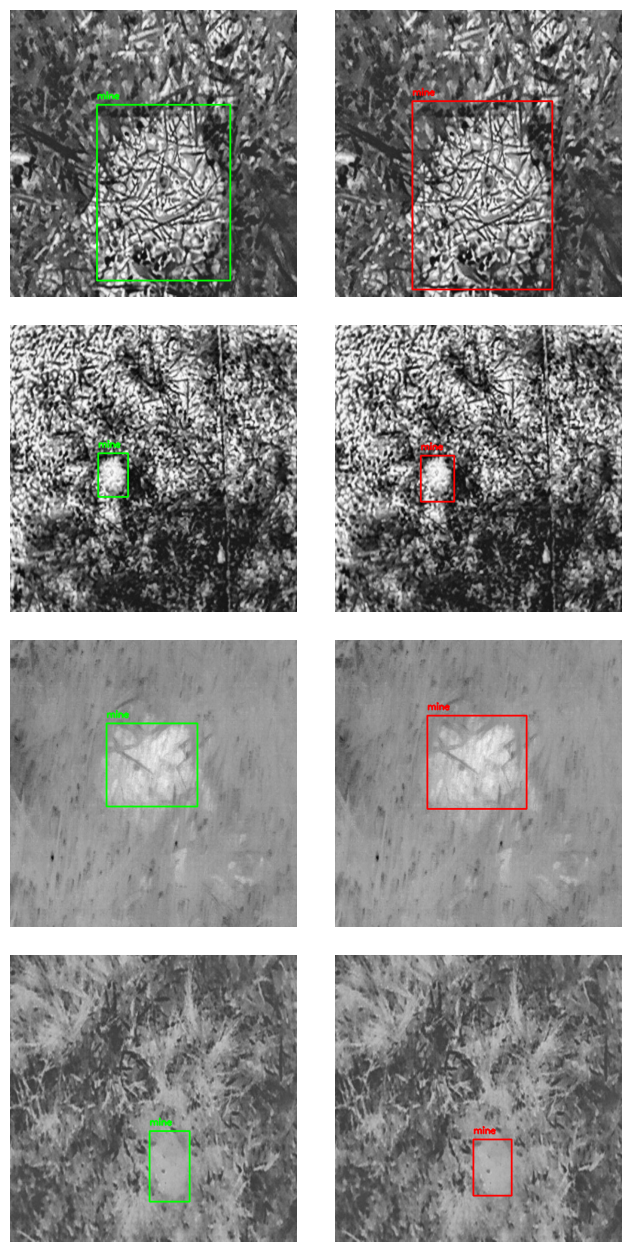

In [30]:
fig, axes = plt.subplots(4, 2, figsize=(8, 16))  # Створюємо полотно з 4 рядками та 2 стовпчиками для відображення зображень
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Налаштовуємо простір між підграфіками

imgs, targets = next(iter(val_dl))

model.eval()  # Переводимо модель у режим оцінювання (відключаємо dropout та batch normalization)
with torch.no_grad():  # Вимикаємо обчислення градієнтів під час оцінювання
    output = model([img.to(device) for img in imgs])  # Отримуємо прогнози моделі для зображень

# Проходимося по кожному зображенню та його прогнозам
for i, idx in enumerate(range(len(imgs))):
    img = imgs[idx]  # Отримуємо зображення
    prediction = output[idx]  # Отримуємо прогноз для даного зображення

    # Відображаємо зображення з реальними областями обмежень
    output_img = show_bbox(img, targets[idx], color=(0, 255, 0))  # Колір для реальних областей обмежень: зелений
    axes[i, 0].imshow(output_img)  # Відображаємо зображення на підграфіку
    axes[i, 0].axis("off")  # Вимикаємо відображення вісей координат

    # Відображаємо зображення з передбаченими областями обмежень
    predict = preprocess_bbox(prediction)  # Обробляємо прогноз перед відображенням
    output_img = show_bbox(img, predict, color=(255, 0, 0))  # Колір для передбачених областей обмежень: червоний
    axes[i, 1].imshow(output_img)  # Відображаємо зображення на підграфіку
    axes[i, 1].axis("off")  # Вимикаємо відображення вісей координат

plt.show()

# 15.Testing the image.

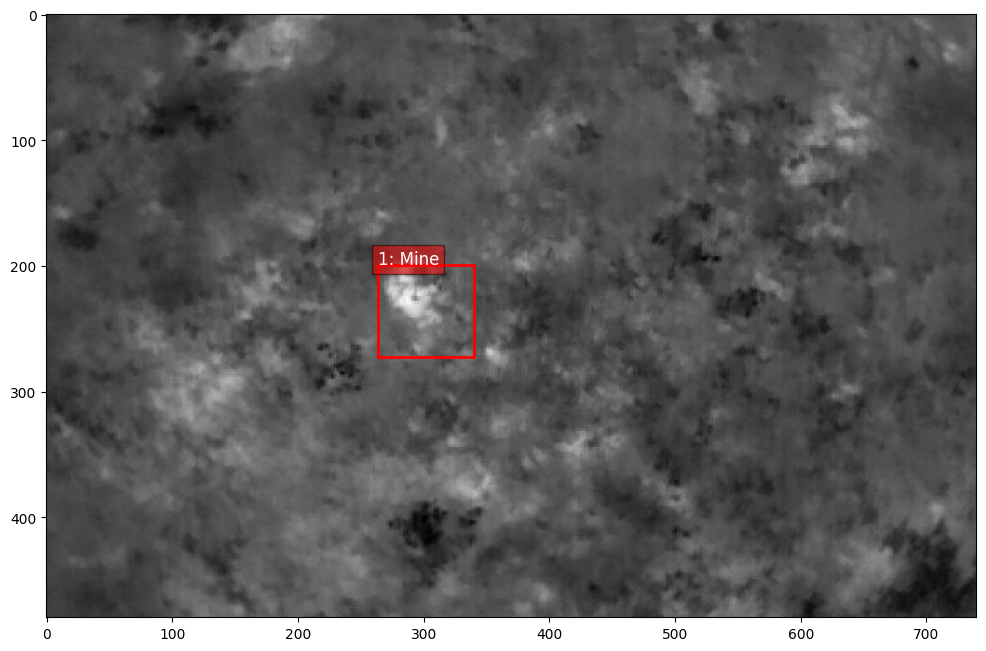

In [37]:
# Шлях до зображення
image_path = "/content/Landmines-5/test/10_Zone_1_Mine_1cm_depth__3-9m_TemperatureInCenter__35-C_jpg.rf.b0dac08608b701cf1c63ba967ec48fe1.jpg"

# Завантаження зображення
img = Image.open(image_path).convert("RGB")

# Передобробка зображення
img_tensor = tf.to_tensor(img)
img_tensor = img_tensor.unsqueeze(0)  # Додати розмір пакету, якщо відсутній

# Прогнозування
model.eval()
with torch.no_grad():
    img_tensor = img_tensor.to(device)  # Переміщення тензора зображення на той же пристрій, що й модель
    output = model(img_tensor)

# Отримання прогнозованих координат областей обмежень на CPU
prediction = output[0]  # Оскільки у нас лише одне зображення, беремо перший прогноз
boxes = output[0]['boxes'].cpu().numpy()
scores = output[0]['scores'].cpu().numpy()
labels = output[0]['labels'].cpu().numpy()

# Встановлення порогу впевненості
confidence_threshold = 0.5

# Фільтрація прогнозів з низькою впевненістю
high_conf_indices = scores >= confidence_threshold
boxes = boxes[high_conf_indices]
scores = scores[high_conf_indices]
labels = labels[high_conf_indices]

# Створення графіку для відображення зображення та областей обмежень
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

# Додавання областей обмежень на графік
for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin

    # Створення прямокутного патчу
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Додавання патчу на графік
    ax.add_patch(rect)

    # Додавання мітки та балу впевненості до області обмеження
    if score <= 1:
        ax.text(xmin, ymin, f'{label}: Mine', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    else:
        ax.text(xmin, ymin, f'{label}: Background', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

# Відображення графіка
plt.show()
